In [1]:
import sys
sys.path.append("../src")

import os
import concurrent.futures

import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib.colors import LinearSegmentedColormap

from utils import (
    WSIDataset, get_args, save_results, 
    extract_coords, merge_patches, adjust_coords,
    get_save_dirs, get_model, ResNet, 
    SwinTransformer, BaseMIL, AttentionBasedMIL,
)

/Users/ericmonzon/mambaforge/envs/histology/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = os.path.join("..", "assets", "inference-results", "isolated")

ce_dir = os.path.join(data_dir, "cross-entropy", "grad-accumulation")
fl_dir = os.path.join(data_dir, "focal-loss", "grad-accumulation")

all([os.path.isdir(ce_dir), os.path.isdir(fl_dir)])

True

In [3]:
splits = [split for split in os.listdir(ce_dir)]

ce_splits = [os.path.join(ce_dir, split) for split in splits]
fl_splits = [os.path.join(fl_dir, split) for split in splits]

In [4]:
ce_parquets = [os.path.join(split, "attention-mil-instance-weights.parquet") for split in ce_splits]

fl_parquets = [os.path.join(split, "attention-mil-instance-weights.parquet") for split in fl_splits]

In [59]:
ce_df_test = pd.read_parquet(ce_parquets[0])
ce_df_test["attention_weights"] = ce_df_test["attention_weights"].map(lambda x: (x - x.min()) / (x.max() - x.min()))

ce_df_test.head()

,patient_id,attention_weights
0,14917C,"[0.014306719, 0.015673196, 0.013457889, 0.0155..."
1,16421,"[0.027221013, 0.023897085, 0.01923266, 0.00560..."
2,11293,"[0.030792331, 0.017403731, 0.041909818, 0.0688..."
3,14696B,"[0.008335913, 0.011395289, 0.00418025, 0.01333..."
4,13645,"[0.020124326, 0.023008393, 0.015153953, 0.0216..."


In [60]:
fl_df_test = pd.read_parquet(fl_parquets[0])
fl_df_test["attention_weights"] = fl_df_test["attention_weights"].map(lambda x: (x - x.min()) / (x.max() - x.min()))

fl_df_test.head()

,patient_id,attention_weights
0,14917C,"[0.21000342, 0.23331131, 0.20958428, 0.2452151..."
1,16421,"[0.24543594, 0.2279877, 0.24398257, 0.21331155..."
2,11293,"[0.23335479, 0.21706581, 0.18948369, 0.3178776..."
3,14696B,"[0.1317889, 0.17387077, 0.073231265, 0.0829488..."
4,13645,"[0.16219383, 0.13928854, 0.11109364, 0.1671657..."


In [61]:
ce_concatenated_attention = np.concat(ce_df_test["attention_weights"])

fl_concatenated_attention = np.concat(fl_df_test["attention_weights"])

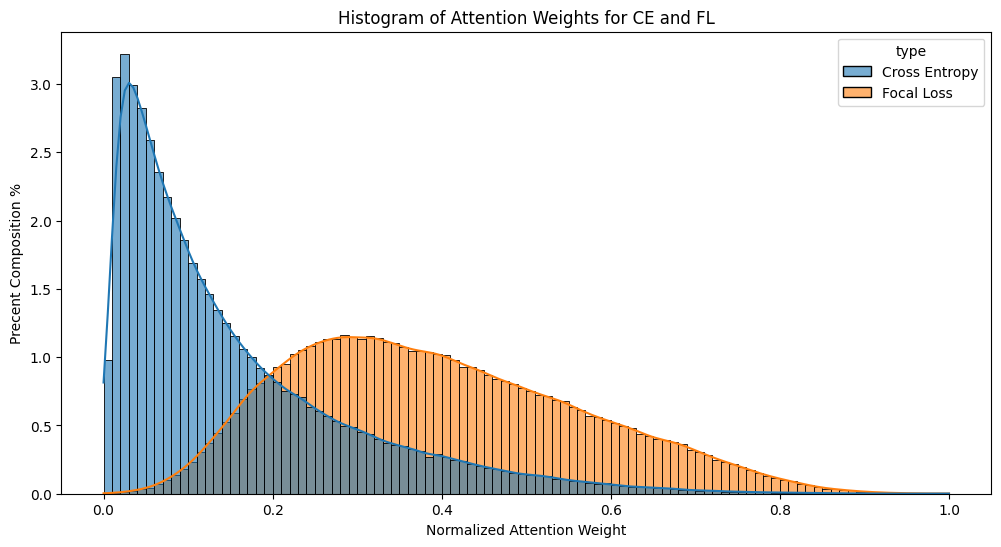

In [62]:
combined_df = pd.DataFrame({
    "attention_weights": np.concatenate([ce_concatenated_attention, fl_concatenated_attention]),
    "type": ["Cross Entropy"] * len(ce_concatenated_attention) + ["Focal Loss"] * len(fl_concatenated_attention)
})

plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x="attention_weights", hue="type", bins=100, kde=True, stat="percent", alpha=0.6)

plt.title("Histogram of Attention Weights for CE and FL")
plt.xlabel("Normalized Attention Weight")
plt.ylabel("Precent Composition %")

plt.show()

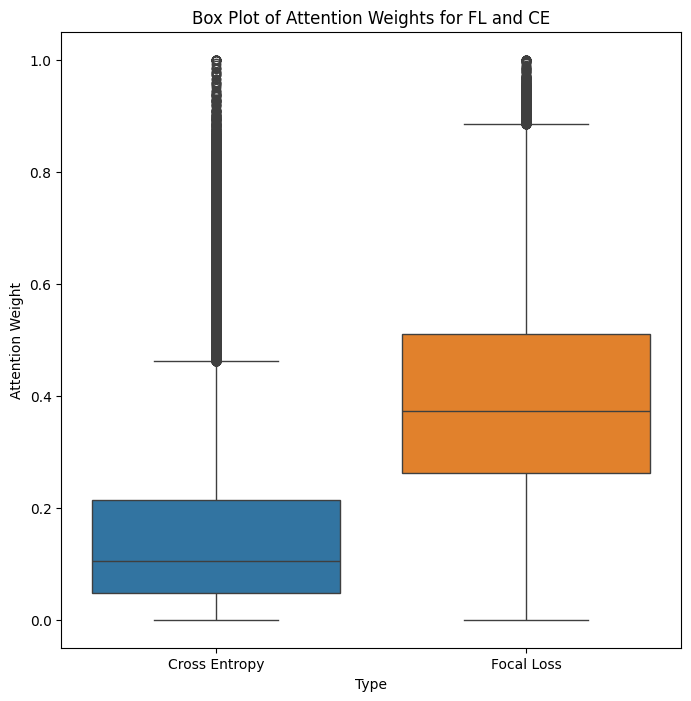

In [26]:
plt.figure(figsize=(8, 8))
sns.boxplot(x="type", y="attention_weights", data=combined_df, hue="type")
plt.title("Box Plot of Attention Weights for FL and CE")
plt.xlabel("Type")
plt.ylabel("Attention Weight")
plt.show()

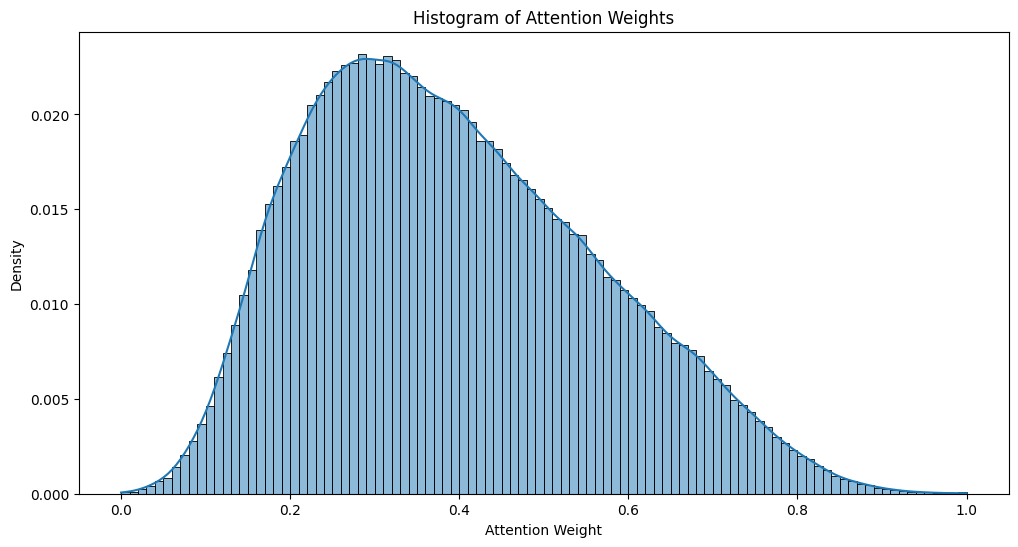

In [37]:
# FL

plt.figure(figsize=(12, 6))
sns.histplot(fl_concatenated_attention, bins=100, kde=True, stat="probability")
plt.title("Histogram of Attention Weights")
plt.xlabel("Attention Weight")
plt.ylabel("Density")
plt.show()

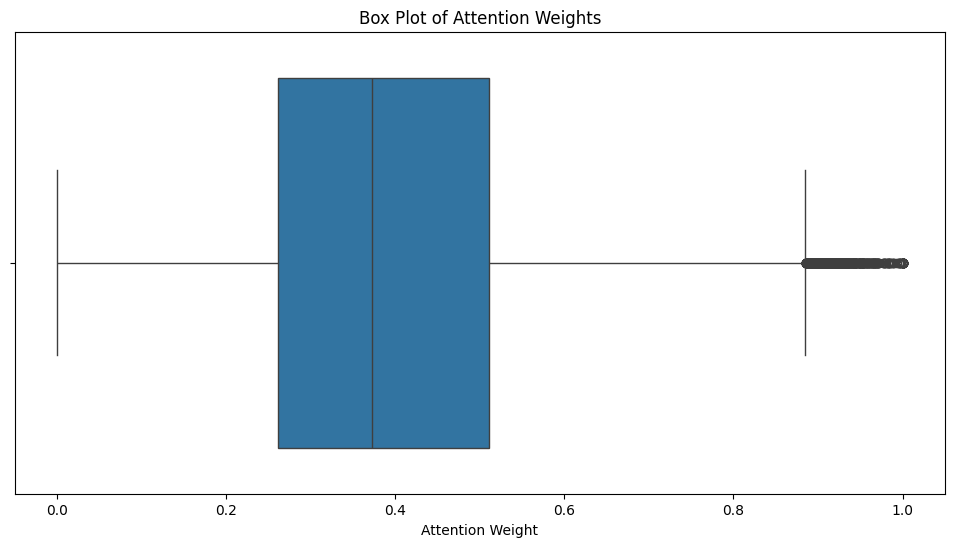

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=fl_concatenated_attention.flatten())
plt.title("Box Plot of Attention Weights")
plt.xlabel("Attention Weight")
plt.show()

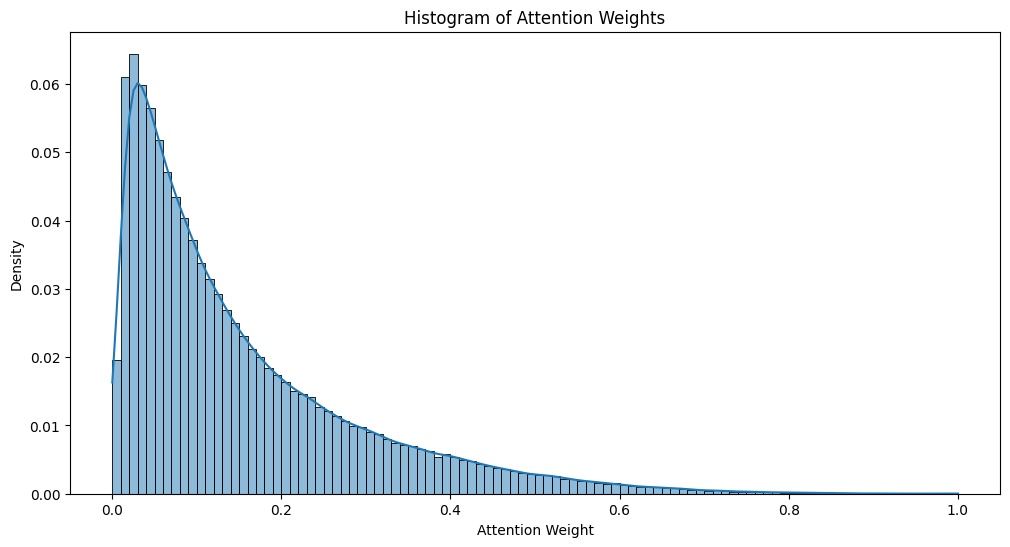

In [33]:
# CE

plt.figure(figsize=(12, 6))
sns.histplot(ce_concatenated_attention, bins=100, kde=True, stat="probability")
plt.title("Histogram of Attention Weights")
plt.xlabel("Attention Weight")
plt.ylabel("Density")
plt.show()

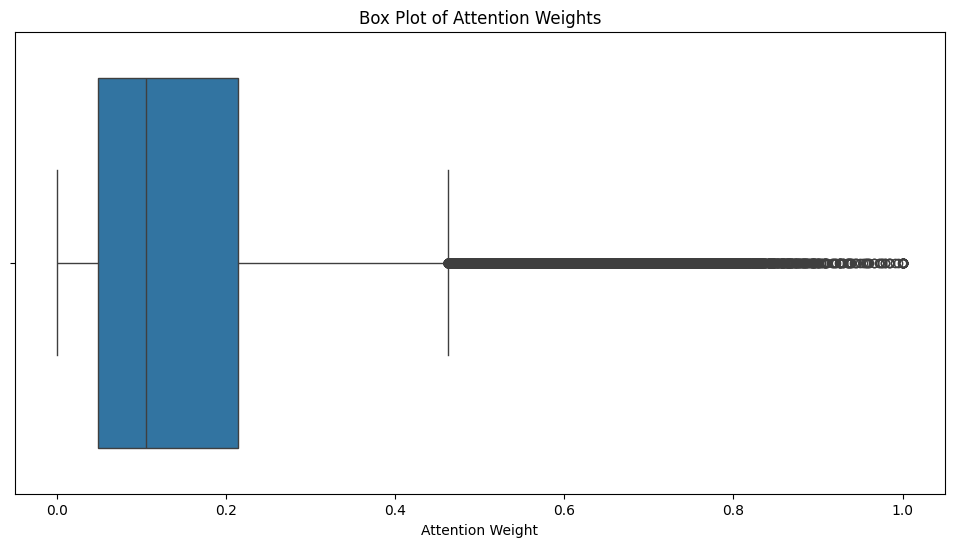

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=ce_concatenated_attention.flatten())
plt.title("Box Plot of Attention Weights")
plt.xlabel("Attention Weight")
plt.show()